### PIDs and using wpilib's PID controller - 2021 1212 CJH
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import wpilib
from wpilib import controller

### the standard PID control equation looks like this:
## ${u(t)} = K_p e(t) + K_i \int e(t)\, dt + K_d \frac{de}{dt}$
### or, since computers rarely actually do calculus,
## ${u(t)} = K_p e(t) + K_i \sum \limits _{j=1} ^{n} e(t_j){\Delta}t + K_d \frac{(e(t)-e(t-{\Delta}t))}{{\Delta}t}$
Where
* u(t) is the output of the controller - usually power from -100% to 100%
* e(t) is the error = **(setpoint - measured value)** at time t
* and the gains, which the user inputs to the model, are
  * Kp is the proportional gain - the farther away from the setpoint, the more power is applied (like a spring)
  * Ki is the integral gain - the sum of all of the old errors times the time between measurements
  * Kd is the derivative gain - looks at the change in the error **(error now - previous error)** and slows you down - (like a shock absorber)


### Do some simple tests with static models

In [2]:
def clamp(value: float, bottom: float, top: float) -> float:
    return max(bottom, min(value, top))

### How about an elevator acting under gravity
* calculate PID response for a simple elevator
* elevator is acted on by an acceleration a (down) and a motor (pid output * motor_scale * a) up 
* each loop we calculate
  * acceleration (y_tt), velocity (y_t) and position (y)
  * the error, the sum of the error and the change in error
  * the pid response

In [5]:
def calc_pids(kp=0, ki=0, kd=0, setpoint=7, y_0=0, motor_scale=2):
# set up the array of times
    x = np.linspace(0,4,100) # four seconds of data
    dt = x[1]-x[0]

    # set the initial conditions
    y = y_0
    y_t = 0

    setpoint = setpoint
    sum_error = 0
    previous_error = 0
    a = 10

    # initialize the two arrays we calculate
    position = []
    velocity = []
    accel = []
    pid = []

    # calculate the error and position at each point
    for t in x:
        error = setpoint - y
        sum_error += error
        output = kp * error + ki * sum_error * dt + kd * (error-previous_error)/dt
        output = clamp(output, -1, 1)
        previous_error = error

        # forces, velocity, position
        y_tt = -a + motor_scale * a * output  # fake it, make the motor 2x gravity at full power
        y_t += y_tt * dt  # velocity is at
        y += y_t * dt
        y = 0 if y < 0 else y
        y_t = 0 if y <= 0 else y_t

        position.append(y)
        velocity.append(y_t)
        pid.append(output)
        accel.append(y_tt)
        
    return x, position, velocity, pid, accel

def plot_elevator(kp=0, ki=0, kd=0, setpoint=7, y_0=0, motor_scale=2, label='',):
    
    x, position, velocity, pid, accel = calc_pids(kp=kp, ki=ki, kd=kd, setpoint=setpoint, y_0=y_0, motor_scale=motor_scale)
    #start the figure
    fig = plt.figure(figsize=(12,8))
    # set height ratios for subplots
    gs = gridspec.GridSpec(4, 1, height_ratios=[2, 1, 1, 1]) 

    # the first subplot
    ax1 = plt.subplot(gs[0])
    line_1, = ax1.plot(x, position, color='g', label='position')
    ax1.axhline(y=setpoint, color='g', lw=1, linestyle='--', label='setpoint')

    ax4 = plt.subplot(gs[3])
    line_4, = ax4.plot(x, pid, color='k', label='PID')


    ax2 = plt.subplot(gs[1])
    line_2, = ax2.plot(x, velocity, color='b', label='velocity')
    ax2.axhline(y=0, color='b', lw=1, linestyle='--', label='')

    ax3 = plt.subplot(gs[2])
    line_3, = ax3.plot(x, accel, color='r', label='acceleration')

    # format the chart
    ax1.set_title(f'{label} (kp={kp},ki={ki},kd={kd}) PID output,  setpoint = {setpoint}', fontsize=14)
    ax1.set_ylabel('measured position', color='g', fontsize=14)
    ax2.set_ylabel('velocity', color='b', fontsize=14, rotation=90, ha='center', labelpad=0)
    ax3.set_ylabel('accel', color='r', fontsize=14, rotation=90, ha='center', labelpad=0)
    ax4.set_ylabel('PID', color='k', fontsize=14, rotation=90, ha='center', labelpad=0)
    ax4.set_xlabel(f'time', fontsize=14)
    ax3.set_xticks([])
    
    [ax.legend(loc='lower right', prop={'size': 12}) for ax in [ax1, ax2, ax3, ax4]]
    # remove vertical gap between subplots
    plt.subplots_adjust(hspace=0)

    return fig

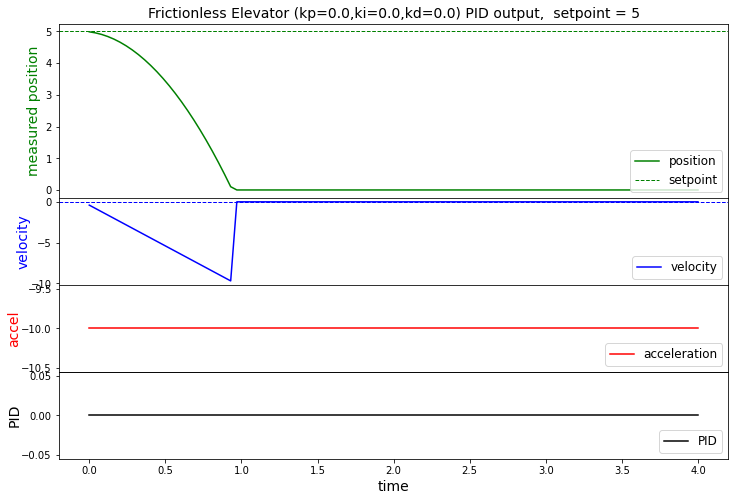

In [6]:
# set the gains
kp, ki, kd = 0.0, 0.0, 0.0
#kp, ki, kd = 0.9, 0.2, 0.1
#kp, ki, kd = 1.8, 0.5, 0.2
setpoint = 5
y_0 = 5
_ = plot_elevator(kp=kp, ki=ki, kd=kd, setpoint=setpoint, y_0=y_0, label='Frictionless Elevator', motor_scale=2)